# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy
import torch

sns.set_theme()

In [3]:
from subpair import extract, pairwise_cosine

# Setup

In [17]:
img_folder = Path("../higherANML/experiments/data/ImageNet84")
feats_folder = Path("/users/l/f/lfrati/scratch/OmnImage_data/torchvision.models.vgg_ce631fc9ca0278a2")
cls2label = {}
with open(img_folder / "imagenet_class_index.json") as f:
    class_idx = json.load(f)
    cls2label = dict(class_idx.values())

In [42]:
all_feature_files = sorted(feats_folder.iterdir())
imgcls_file = all_feature_files[0]
imgcls = imgcls_file.stem
print(f"Working with class: {imgcls} ({cls2label[imgcls]})")

Working with class: n01440764 (tench)


In [50]:
X = np.load(imgcls_file)

In [51]:
distances = pairwise_cosine(X)

In [52]:
num_samples = 750
best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)

100%|██████████| 3000/3000 [05:32<00:00,  9.01it/s]


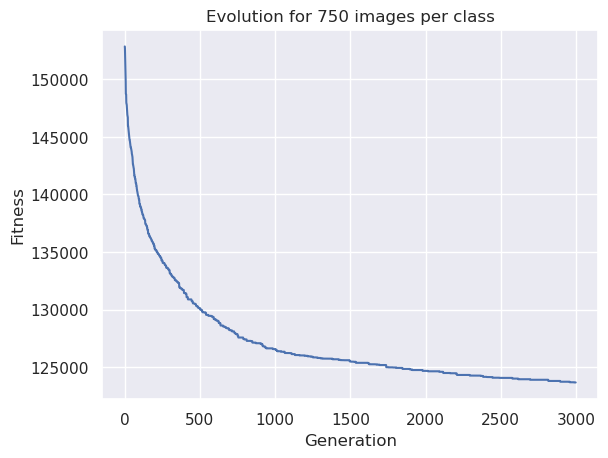

In [53]:
plt.plot(stats["fits"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
_ = plt.title(f"Evolution for {num_samples} images per class")

# Single Class Analysis

In [90]:
imgcls_file = np.random.choice(all_feature_files)
imgcls = imgcls_file.stem
print(f"Computing image distances for class: {imgcls} ({cls2label[imgcls]})")
X = np.load(imgcls_file)
distances = pairwise_cosine(X)

Computing image distances for class: n04355933 (sunglass)


In [91]:
sample_sizes = [10, 20, 50, 100, 200, 500]
results = []
for i, num_samples in enumerate(sample_sizes):
    best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
    results.append({"num_samples": num_samples, "best": best, "stats": stats})

100%|██████████| 3000/3000 [00:33<00:00, 90.24it/s]


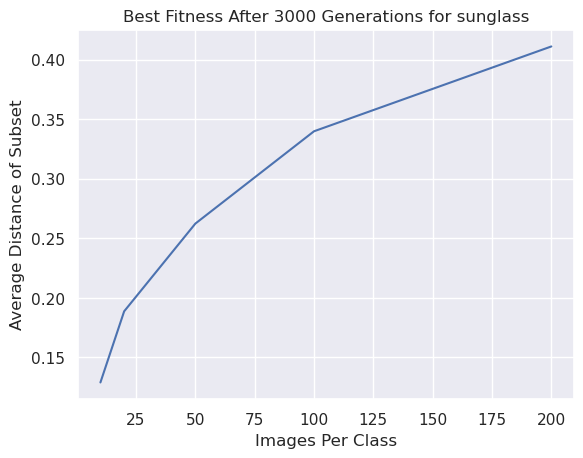

In [92]:
final_fitnesses = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, results)]
plt.plot(sample_sizes, final_fitnesses)
plt.xlabel("Images Per Class")
plt.ylabel("Average Distance of Subset")
_ = plt.title(f"Best Fitness After 3000 Generations for {cls2label[imgcls]}")

# Aggregating Multiple Classes

In [95]:
import itertools


def compute_evolved_subsets(distances, sample_sizes=None):
    if not sample_sizes:
        sample_sizes = [10, 20, 50, 100, 200, 500]
    results = []
    for i, num_samples in enumerate(sample_sizes):
        best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
        results.append({"num_samples": num_samples, "best": best, "stats": stats})
    return results


def compute_evolved_distances_for_class(imgcls_file, sample_sizes):
    imgcls = imgcls_file.stem
    X = np.load(imgcls_file)
    distances = pairwise_cosine(X)
    avg_dists = compute_evolved_subsets(distances, sample_sizes)
    return [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, avg_dists)]


def get_fitnesses_for_classes(num_classes=None):
    if num_classes is None:
        cls_files = all_feature_files
    else:
        cls_files = np.random.choice(all_feature_files, size=num_classes, replace=False)
    total = len(cls_files)

    sample_sizes = [10, 20, 50, 100, 200]
    records = []
    for i, f in enumerate(cls_files):
        clsid = f.stem
        clsname = cls2label[clsid]
        print(f"Computing evolved subsets for class {i}/{total}: {clsid} ({clsname})")
        dists = compute_evolved_distances_for_class(f, sample_sizes)
        records.extend(zip(itertools.repeat(clsid), itertools.repeat(clsname), sample_sizes, dists))
    
    return pd.DataFrame.from_records(records, columns=("Class ID", "Label", "Subset Size", "Avg. Dist."))

In [99]:
df = get_fitnesses_for_classes()

Computing evolved subsets for class: n01440764 (tench)


100%|██████████| 3000/3000 [00:33<00:00, 90.04it/s]


Computing evolved subsets for class: n01443537 (goldfish)


100%|██████████| 3000/3000 [00:33<00:00, 88.78it/s]


Computing evolved subsets for class: n01484850 (great_white_shark)


100%|██████████| 3000/3000 [00:33<00:00, 89.47it/s]


Computing evolved subsets for class: n01491361 (tiger_shark)


100%|██████████| 3000/3000 [00:33<00:00, 88.65it/s]


Computing evolved subsets for class: n01494475 (hammerhead)


100%|██████████| 3000/3000 [00:34<00:00, 87.53it/s]


Computing evolved subsets for class: n01496331 (electric_ray)


100%|██████████| 3000/3000 [00:33<00:00, 88.72it/s]


Computing evolved subsets for class: n01498041 (stingray)


100%|██████████| 3000/3000 [00:33<00:00, 88.34it/s]


Computing evolved subsets for class: n01514668 (cock)


100%|██████████| 3000/3000 [00:44<00:00, 66.71it/s]


Computing evolved subsets for class: n01514859 (hen)


100%|██████████| 3000/3000 [00:34<00:00, 85.95it/s]


Computing evolved subsets for class: n01518878 (ostrich)


100%|██████████| 3000/3000 [00:34<00:00, 85.86it/s]


Computing evolved subsets for class: n01530575 (brambling)


100%|██████████| 3000/3000 [00:33<00:00, 88.33it/s]


Computing evolved subsets for class: n01531178 (goldfinch)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n01532829 (house_finch)


100%|██████████| 3000/3000 [00:33<00:00, 88.83it/s]


Computing evolved subsets for class: n01534433 (junco)


100%|██████████| 3000/3000 [00:33<00:00, 88.66it/s]


Computing evolved subsets for class: n01537544 (indigo_bunting)


100%|██████████| 3000/3000 [00:33<00:00, 89.53it/s]


Computing evolved subsets for class: n01558993 (robin)


100%|██████████| 3000/3000 [00:33<00:00, 88.67it/s]


Computing evolved subsets for class: n01560419 (bulbul)


100%|██████████| 3000/3000 [00:33<00:00, 88.67it/s]


Computing evolved subsets for class: n01580077 (jay)


100%|██████████| 3000/3000 [00:34<00:00, 86.80it/s]


Computing evolved subsets for class: n01582220 (magpie)


100%|██████████| 3000/3000 [00:34<00:00, 88.00it/s]


Computing evolved subsets for class: n01592084 (chickadee)


100%|██████████| 3000/3000 [00:34<00:00, 87.68it/s]


Computing evolved subsets for class: n01601694 (water_ouzel)


100%|██████████| 3000/3000 [00:33<00:00, 89.65it/s]


Computing evolved subsets for class: n01608432 (kite)


100%|██████████| 3000/3000 [00:33<00:00, 89.15it/s]


Computing evolved subsets for class: n01614925 (bald_eagle)


100%|██████████| 3000/3000 [00:33<00:00, 88.63it/s]


Computing evolved subsets for class: n01616318 (vulture)


100%|██████████| 3000/3000 [00:33<00:00, 88.96it/s]


Computing evolved subsets for class: n01622779 (great_grey_owl)


100%|██████████| 3000/3000 [00:33<00:00, 89.80it/s]


Computing evolved subsets for class: n01629819 (European_fire_salamander)


100%|██████████| 3000/3000 [00:33<00:00, 88.96it/s]


Computing evolved subsets for class: n01630670 (common_newt)


100%|██████████| 3000/3000 [00:45<00:00, 66.28it/s]


Computing evolved subsets for class: n01631663 (eft)


100%|██████████| 3000/3000 [00:33<00:00, 89.78it/s]


Computing evolved subsets for class: n01632458 (spotted_salamander)


100%|██████████| 3000/3000 [00:33<00:00, 89.75it/s]


Computing evolved subsets for class: n01632777 (axolotl)


100%|██████████| 3000/3000 [00:33<00:00, 89.22it/s]


Computing evolved subsets for class: n01641577 (bullfrog)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n01644373 (tree_frog)


100%|██████████| 3000/3000 [00:33<00:00, 89.28it/s]


Computing evolved subsets for class: n01644900 (tailed_frog)


100%|██████████| 3000/3000 [00:33<00:00, 89.16it/s]


Computing evolved subsets for class: n01664065 (loggerhead)


100%|██████████| 3000/3000 [00:33<00:00, 89.08it/s]


Computing evolved subsets for class: n01665541 (leatherback_turtle)


100%|██████████| 3000/3000 [00:34<00:00, 86.06it/s]


Computing evolved subsets for class: n01667114 (mud_turtle)


100%|██████████| 3000/3000 [00:33<00:00, 88.37it/s]


Computing evolved subsets for class: n01667778 (terrapin)


100%|██████████| 3000/3000 [00:33<00:00, 89.17it/s]


Computing evolved subsets for class: n01669191 (box_turtle)


100%|██████████| 3000/3000 [00:34<00:00, 86.17it/s]


Computing evolved subsets for class: n01675722 (banded_gecko)


100%|██████████| 3000/3000 [00:33<00:00, 89.09it/s]


Computing evolved subsets for class: n01677366 (common_iguana)


100%|██████████| 3000/3000 [00:39<00:00, 75.67it/s]


Computing evolved subsets for class: n01682714 (American_chameleon)


100%|██████████| 3000/3000 [00:33<00:00, 88.97it/s]


Computing evolved subsets for class: n01685808 (whiptail)


100%|██████████| 3000/3000 [00:33<00:00, 89.16it/s]


Computing evolved subsets for class: n01687978 (agama)


100%|██████████| 3000/3000 [00:33<00:00, 90.08it/s]


Computing evolved subsets for class: n01688243 (frilled_lizard)


100%|██████████| 3000/3000 [00:33<00:00, 90.08it/s]


Computing evolved subsets for class: n01689811 (alligator_lizard)


100%|██████████| 3000/3000 [00:34<00:00, 88.00it/s]


Computing evolved subsets for class: n01692333 (Gila_monster)


100%|██████████| 3000/3000 [00:33<00:00, 88.98it/s]


Computing evolved subsets for class: n01693334 (green_lizard)


100%|██████████| 3000/3000 [00:33<00:00, 88.50it/s]


Computing evolved subsets for class: n01694178 (African_chameleon)


100%|██████████| 3000/3000 [00:33<00:00, 88.58it/s]


Computing evolved subsets for class: n01695060 (Komodo_dragon)


100%|██████████| 3000/3000 [00:34<00:00, 86.75it/s]


Computing evolved subsets for class: n01697457 (African_crocodile)


100%|██████████| 3000/3000 [00:34<00:00, 87.74it/s]


Computing evolved subsets for class: n01698640 (American_alligator)


100%|██████████| 3000/3000 [00:36<00:00, 82.73it/s]


Computing evolved subsets for class: n01704323 (triceratops)


100%|██████████| 3000/3000 [00:34<00:00, 87.80it/s]


Computing evolved subsets for class: n01728572 (thunder_snake)


100%|██████████| 3000/3000 [00:35<00:00, 83.75it/s]


Computing evolved subsets for class: n01728920 (ringneck_snake)


100%|██████████| 3000/3000 [00:34<00:00, 87.78it/s]


Computing evolved subsets for class: n01729322 (hognose_snake)


100%|██████████| 3000/3000 [00:33<00:00, 88.25it/s]


Computing evolved subsets for class: n01729977 (green_snake)


100%|██████████| 3000/3000 [00:34<00:00, 87.65it/s]


Computing evolved subsets for class: n01734418 (king_snake)


100%|██████████| 3000/3000 [00:36<00:00, 82.80it/s]


Computing evolved subsets for class: n01735189 (garter_snake)


100%|██████████| 3000/3000 [00:34<00:00, 87.68it/s]


Computing evolved subsets for class: n01737021 (water_snake)


100%|██████████| 3000/3000 [00:33<00:00, 88.97it/s]


Computing evolved subsets for class: n01739381 (vine_snake)


100%|██████████| 3000/3000 [00:33<00:00, 88.97it/s]


Computing evolved subsets for class: n01740131 (night_snake)


100%|██████████| 3000/3000 [00:33<00:00, 89.69it/s]


Computing evolved subsets for class: n01742172 (boa_constrictor)


100%|██████████| 3000/3000 [00:34<00:00, 86.71it/s]


Computing evolved subsets for class: n01744401 (rock_python)


100%|██████████| 3000/3000 [00:33<00:00, 88.66it/s]


Computing evolved subsets for class: n01748264 (Indian_cobra)


100%|██████████| 3000/3000 [00:34<00:00, 86.53it/s]


Computing evolved subsets for class: n01749939 (green_mamba)


100%|██████████| 3000/3000 [00:33<00:00, 88.77it/s]


Computing evolved subsets for class: n01751748 (sea_snake)


100%|██████████| 3000/3000 [00:33<00:00, 89.81it/s]


Computing evolved subsets for class: n01753488 (horned_viper)


100%|██████████| 3000/3000 [00:35<00:00, 85.20it/s]


Computing evolved subsets for class: n01755581 (diamondback)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n01756291 (sidewinder)


100%|██████████| 3000/3000 [00:33<00:00, 90.36it/s]


Computing evolved subsets for class: n01768244 (trilobite)


100%|██████████| 3000/3000 [00:33<00:00, 89.08it/s]


Computing evolved subsets for class: n01770081 (harvestman)


100%|██████████| 3000/3000 [00:34<00:00, 86.35it/s]


Computing evolved subsets for class: n01770393 (scorpion)


100%|██████████| 3000/3000 [00:34<00:00, 86.55it/s]


Computing evolved subsets for class: n01773157 (black_and_gold_garden_spider)


100%|██████████| 3000/3000 [00:33<00:00, 88.67it/s]


Computing evolved subsets for class: n01773549 (barn_spider)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n01773797 (garden_spider)


100%|██████████| 3000/3000 [00:33<00:00, 89.27it/s]


Computing evolved subsets for class: n01774384 (black_widow)


100%|██████████| 3000/3000 [00:34<00:00, 87.31it/s]


Computing evolved subsets for class: n01774750 (tarantula)


100%|██████████| 3000/3000 [00:33<00:00, 88.94it/s]


Computing evolved subsets for class: n01775062 (wolf_spider)


100%|██████████| 3000/3000 [00:33<00:00, 88.51it/s]


Computing evolved subsets for class: n01776313 (tick)


100%|██████████| 3000/3000 [00:33<00:00, 88.35it/s]


Computing evolved subsets for class: n01784675 (centipede)


100%|██████████| 3000/3000 [00:33<00:00, 89.20it/s]


Computing evolved subsets for class: n01795545 (black_grouse)


100%|██████████| 3000/3000 [00:33<00:00, 89.34it/s]


Computing evolved subsets for class: n01796340 (ptarmigan)


100%|██████████| 3000/3000 [00:33<00:00, 88.46it/s]


Computing evolved subsets for class: n01797886 (ruffed_grouse)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n01798484 (prairie_chicken)


100%|██████████| 3000/3000 [00:33<00:00, 88.26it/s]


Computing evolved subsets for class: n01807496 (partridge)


100%|██████████| 3000/3000 [00:33<00:00, 88.84it/s]


Computing evolved subsets for class: n01817953 (African_grey)


100%|██████████| 3000/3000 [00:33<00:00, 89.92it/s]


Computing evolved subsets for class: n01818515 (macaw)


100%|██████████| 3000/3000 [00:33<00:00, 89.50it/s]


Computing evolved subsets for class: n01819313 (sulphur-crested_cockatoo)


100%|██████████| 3000/3000 [00:33<00:00, 88.49it/s]


Computing evolved subsets for class: n01820546 (lorikeet)


 98%|█████████▊| 2938/3000 [00:13<00:00, 259.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.07it/s]


Computing evolved subsets for class: n01945685 (slug)


100%|██████████| 3000/3000 [00:33<00:00, 88.47it/s]


Computing evolved subsets for class: n01950731 (sea_slug)


100%|██████████| 3000/3000 [00:33<00:00, 89.36it/s]


Computing evolved subsets for class: n01955084 (chiton)


100%|██████████| 3000/3000 [00:33<00:00, 89.33it/s]


Computing evolved subsets for class: n01968897 (chambered_nautilus)


100%|██████████| 3000/3000 [00:33<00:00, 90.51it/s]


Computing evolved subsets for class: n01978287 (Dungeness_crab)


 39%|███▉      | 1176/3000 [00:04<00:07, 259.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.33it/s]


Computing evolved subsets for class: n02027492 (red-backed_sandpiper)


100%|██████████| 3000/3000 [00:33<00:00, 88.24it/s]


Computing evolved subsets for class: n02028035 (redshank)


100%|██████████| 3000/3000 [00:33<00:00, 90.10it/s]


Computing evolved subsets for class: n02033041 (dowitcher)


100%|██████████| 3000/3000 [00:33<00:00, 89.96it/s]


Computing evolved subsets for class: n02037110 (oystercatcher)


 64%|██████▍   | 1928/3000 [00:21<00:12, 89.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:32<00:00, 93.32it/s]


Computing evolved subsets for class: n02089973 (English_foxhound)


100%|██████████| 3000/3000 [00:30<00:00, 98.82it/s] 


Computing evolved subsets for class: n02090379 (redbone)


100%|██████████| 3000/3000 [00:33<00:00, 89.88it/s]


Computing evolved subsets for class: n02090622 (borzoi)


100%|██████████| 3000/3000 [00:33<00:00, 88.45it/s]


Computing evolved subsets for class: n02090721 (Irish_wolfhound)


100%|██████████| 3000/3000 [00:33<00:00, 90.00it/s]


Computing evolved subsets for class: n02091032 (Italian_greyhound)


100%|██████████| 3000/3000 [00:33<00:00, 88.83it/s]


Computing evolved subsets for class: n02091134 (whippet)


 94%|█████████▎| 2805/3000 [00:03<00:00, 708.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 88.43it/s]


Computing evolved subsets for class: n02097047 (miniature_schnauzer)


100%|██████████| 3000/3000 [00:33<00:00, 90.19it/s]


Computing evolved subsets for class: n02097130 (giant_schnauzer)


100%|██████████| 3000/3000 [00:33<00:00, 90.69it/s]


Computing evolved subsets for class: n02097209 (standard_schnauzer)


100%|██████████| 3000/3000 [00:33<00:00, 90.22it/s]


Computing evolved subsets for class: n02097298 (Scotch_terrier)


100%|██████████| 3000/3000 [00:34<00:00, 86.82it/s]


Computing evolved subsets for class: n02097474 (Tibetan_terrier)


 17%|█▋        | 510/3000 [00:05<00:27, 91.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.12it/s]


Computing evolved subsets for class: n02104365 (schipperke)


100%|██████████| 3000/3000 [00:33<00:00, 90.19it/s]


Computing evolved subsets for class: n02105056 (groenendael)


100%|██████████| 3000/3000 [00:33<00:00, 90.45it/s]


Computing evolved subsets for class: n02105162 (malinois)


100%|██████████| 3000/3000 [00:33<00:00, 89.36it/s]


Computing evolved subsets for class: n02105251 (briard)


100%|██████████| 3000/3000 [00:33<00:00, 88.44it/s]


Computing evolved subsets for class: n02105412 (kelpie)


 97%|█████████▋| 2910/3000 [00:33<00:00, 90.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.04it/s]


Computing evolved subsets for class: n02110341 (dalmatian)


100%|██████████| 3000/3000 [00:33<00:00, 89.93it/s]


Computing evolved subsets for class: n02110627 (affenpinscher)


100%|██████████| 3000/3000 [00:31<00:00, 94.61it/s]


Computing evolved subsets for class: n02110806 (basenji)


100%|██████████| 3000/3000 [00:33<00:00, 88.39it/s]


Computing evolved subsets for class: n02110958 (pug)


100%|██████████| 3000/3000 [00:33<00:00, 90.42it/s]


Computing evolved subsets for class: n02111129 (Leonberg)


  4%|▍         | 129/3000 [00:01<00:31, 90.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.71it/s]


Computing evolved subsets for class: n02119789 (kit_fox)


100%|██████████| 3000/3000 [00:33<00:00, 89.70it/s]


Computing evolved subsets for class: n02120079 (Arctic_fox)


100%|██████████| 3000/3000 [00:33<00:00, 89.96it/s]


Computing evolved subsets for class: n02120505 (grey_fox)


100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


Computing evolved subsets for class: n02123045 (tabby)


100%|██████████| 3000/3000 [00:33<00:00, 90.23it/s]


Computing evolved subsets for class: n02123159 (tiger_cat)


 84%|████████▎ | 2507/3000 [00:28<00:05, 91.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.38it/s]


Computing evolved subsets for class: n02172182 (dung_beetle)


100%|██████████| 3000/3000 [00:33<00:00, 90.57it/s]


Computing evolved subsets for class: n02174001 (rhinoceros_beetle)


100%|██████████| 3000/3000 [00:33<00:00, 90.44it/s]


Computing evolved subsets for class: n02177972 (weevil)


100%|██████████| 3000/3000 [00:33<00:00, 89.50it/s]


Computing evolved subsets for class: n02190166 (fly)


100%|██████████| 3000/3000 [00:33<00:00, 90.88it/s]


Computing evolved subsets for class: n02206856 (bee)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n02219486 (ant)


 24%|██▍       | 720/3000 [00:01<00:03, 716.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.36it/s]


Computing evolved subsets for class: n02342885 (hamster)


100%|██████████| 3000/3000 [00:33<00:00, 90.40it/s]


Computing evolved subsets for class: n02346627 (porcupine)


100%|██████████| 3000/3000 [00:33<00:00, 90.08it/s]


Computing evolved subsets for class: n02356798 (fox_squirrel)


100%|██████████| 3000/3000 [00:32<00:00, 91.42it/s]


Computing evolved subsets for class: n02361337 (marmot)


100%|██████████| 3000/3000 [00:33<00:00, 89.03it/s]


Computing evolved subsets for class: n02363005 (beaver)


  2%|▏         | 60/3000 [00:00<00:32, 91.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.32it/s]


Computing evolved subsets for class: n02444819 (otter)


100%|██████████| 3000/3000 [00:34<00:00, 87.05it/s]


Computing evolved subsets for class: n02445715 (skunk)


100%|██████████| 3000/3000 [00:33<00:00, 88.68it/s]


Computing evolved subsets for class: n02447366 (badger)


100%|██████████| 3000/3000 [00:33<00:00, 89.35it/s]


Computing evolved subsets for class: n02454379 (armadillo)


100%|██████████| 3000/3000 [00:33<00:00, 88.71it/s]


Computing evolved subsets for class: n02457408 (three-toed_sloth)


 30%|██▉       | 889/3000 [00:10<00:23, 91.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.06it/s]


Computing evolved subsets for class: n02509815 (lesser_panda)


100%|██████████| 3000/3000 [00:34<00:00, 87.91it/s]


Computing evolved subsets for class: n02510455 (giant_panda)


100%|██████████| 3000/3000 [00:33<00:00, 88.64it/s]


Computing evolved subsets for class: n02514041 (barracouta)


100%|██████████| 3000/3000 [00:33<00:00, 89.49it/s]


Computing evolved subsets for class: n02526121 (eel)


100%|██████████| 3000/3000 [00:32<00:00, 91.45it/s]


Computing evolved subsets for class: n02536864 (coho)


100%|██████████| 3000/3000 [00:33<00:00, 89.47it/s]


Computing evolved subsets for class: n02606052 (rock_beauty)


 13%|█▎        | 390/3000 [00:00<00:03, 769.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.53it/s]


Computing evolved subsets for class: n02776631 (bakery)


100%|██████████| 3000/3000 [00:33<00:00, 88.42it/s]


Computing evolved subsets for class: n02777292 (balance_beam)


100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


Computing evolved subsets for class: n02782093 (balloon)


100%|██████████| 3000/3000 [00:33<00:00, 89.96it/s]


Computing evolved subsets for class: n02783161 (ballpoint)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n02786058 (Band_Aid)


 16%|█▌        | 480/3000 [00:05<00:27, 90.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


Computing evolved subsets for class: n02825657 (bell_cote)


100%|██████████| 3000/3000 [00:33<00:00, 90.81it/s]


Computing evolved subsets for class: n02834397 (bib)


100%|██████████| 3000/3000 [00:33<00:00, 90.59it/s]


Computing evolved subsets for class: n02835271 (bicycle-built-for-two)


100%|██████████| 3000/3000 [00:33<00:00, 89.22it/s]


Computing evolved subsets for class: n02837789 (bikini)


100%|██████████| 3000/3000 [00:33<00:00, 89.83it/s]


Computing evolved subsets for class: n02840245 (binder)


 76%|███████▋  | 2290/3000 [00:25<00:07, 90.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:32<00:00, 91.68it/s]


Computing evolved subsets for class: n02917067 (bullet_train)


 82%|████████▏ | 2449/3000 [00:27<00:06, 91.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.60it/s]


Computing evolved subsets for class: n02948072 (candle)


100%|██████████| 3000/3000 [00:33<00:00, 89.92it/s]


Computing evolved subsets for class: n02950826 (cannon)


100%|██████████| 3000/3000 [00:33<00:00, 90.28it/s]


Computing evolved subsets for class: n02951358 (canoe)


 95%|█████████▍| 2846/3000 [00:31<00:01, 91.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.91it/s]


Computing evolved subsets for class: n03016953 (chiffonier)


100%|██████████| 3000/3000 [00:33<00:00, 88.87it/s]


Computing evolved subsets for class: n03017168 (chime)


 30%|███       | 915/3000 [00:03<00:08, 257.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 88.54it/s]


Computing evolved subsets for class: n03028079 (church)


100%|██████████| 3000/3000 [00:33<00:00, 90.24it/s]


Computing evolved subsets for class: n03032252 (cinema)


100%|██████████| 3000/3000 [00:33<00:00, 90.00it/s]


Computing evolved subsets for class: n03041632 (cleaver)


100%|██████████| 3000/3000 [00:32<00:00, 92.59it/s]


Computing evolved subsets for class: n03042490 (cliff_dwelling)


 36%|███▌      | 1071/3000 [00:01<00:02, 705.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.16it/s]


Computing evolved subsets for class: n03131574 (crib)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n03133878 (Crock_Pot)


 99%|█████████▉| 2966/3000 [00:11<00:00, 261.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n03146219 (cuirass)


100%|██████████| 3000/3000 [00:33<00:00, 90.54it/s]


Computing evolved subsets for class: n03160309 (dam)


100%|██████████| 3000/3000 [00:33<00:00, 90.48it/s]


Computing evolved subsets for class: n03179701 (desk)


100%|██████████| 3000/3000 [00:33<00:00, 90.11it/s]


Computing evolved subsets for class: n03180011 (desktop_computer)


  8%|▊         | 244/3000 [00:02<00:30, 89.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.90it/s]


Computing evolved subsets for class: n03290653 (entertainment_center)


 75%|███████▌  | 2253/3000 [00:25<00:08, 90.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:32<00:00, 92.04it/s]


Computing evolved subsets for class: n03325584 (feather_boa)


100%|██████████| 3000/3000 [00:33<00:00, 90.05it/s]


Computing evolved subsets for class: n03337140 (file)


100%|██████████| 3000/3000 [00:33<00:00, 90.11it/s]


Computing evolved subsets for class: n03344393 (fireboat)


 91%|█████████▏| 2743/3000 [00:30<00:02, 89.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n03445924 (golfcart)


100%|██████████| 3000/3000 [00:33<00:00, 90.08it/s]


Computing evolved subsets for class: n03447447 (gondola)


 17%|█▋        | 500/3000 [00:00<00:03, 706.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.10it/s]


Computing evolved subsets for class: n03452741 (grand_piano)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n03457902 (greenhouse)


100%|██████████| 3000/3000 [00:47<00:00, 63.69it/s]


Computing evolved subsets for class: n03459775 (grille)


 53%|█████▎    | 1578/3000 [00:17<00:15, 89.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.69it/s]


Computing evolved subsets for class: n03535780 (horizontal_bar)


 96%|█████████▋| 2894/3000 [00:32<00:01, 87.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.66it/s]


Computing evolved subsets for class: n03584829 (iron)


100%|██████████| 3000/3000 [00:33<00:00, 90.32it/s]


Computing evolved subsets for class: n03590841 (jack-o'-lantern)


100%|██████████| 3000/3000 [00:33<00:00, 90.26it/s]


Computing evolved subsets for class: n03594734 (jean)


100%|██████████| 3000/3000 [00:33<00:00, 90.28it/s]


Computing evolved subsets for class: n03594945 (jeep)


 26%|██▌       | 781/3000 [00:01<00:03, 704.04it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.13it/s]


Computing evolved subsets for class: n03676483 (lipstick)


100%|██████████| 3000/3000 [00:33<00:00, 90.29it/s]


Computing evolved subsets for class: n03680355 (Loafer)


 25%|██▌       | 756/3000 [00:02<00:08, 264.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.23it/s]


Computing evolved subsets for class: n03692522 (loupe)


100%|██████████| 3000/3000 [00:33<00:00, 90.47it/s]


Computing evolved subsets for class: n03697007 (lumbermill)


100%|██████████| 3000/3000 [00:33<00:00, 90.11it/s]


Computing evolved subsets for class: n03706229 (magnetic_compass)


100%|██████████| 3000/3000 [00:32<00:00, 91.49it/s]


Computing evolved subsets for class: n03709823 (mailbag)


 14%|█▍        | 427/3000 [00:04<00:28, 89.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:58<00:00, 51.16it/s]


Computing evolved subsets for class: n03763968 (military_uniform)


100%|██████████| 3000/3000 [00:33<00:00, 89.46it/s]


Computing evolved subsets for class: n03764736 (milk_can)


100%|██████████| 3000/3000 [00:32<00:00, 91.72it/s]


Computing evolved subsets for class: n03769881 (minibus)


100%|██████████| 3000/3000 [00:33<00:00, 88.48it/s]


Computing evolved subsets for class: n03770439 (miniskirt)


100%|██████████| 3000/3000 [00:33<00:00, 89.87it/s]


Computing evolved subsets for class: n03770679 (minivan)


100%|██████████| 3000/3000 [00:33<00:00, 89.83it/s]


Computing evolved subsets for class: n03773504 (missile)


100%|██████████| 3000/3000 [00:33<00:00, 89.37it/s]


Computing evolved subsets for class: n03775071 (mitten)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n03775546 (mixing_bowl)


100%|██████████| 3000/3000 [00:33<00:00, 89.34it/s]


Computing evolved subsets for class: n03776460 (mobile_home)


100%|██████████| 3000/3000 [00:33<00:00, 89.63it/s]


Computing evolved subsets for class: n03777568 (Model_T)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n03777754 (modem)


100%|██████████| 3000/3000 [00:33<00:00, 89.76it/s]


Computing evolved subsets for class: n03781244 (monastery)


100%|██████████| 3000/3000 [00:33<00:00, 89.45it/s]


Computing evolved subsets for class: n03782006 (monitor)


100%|██████████| 3000/3000 [00:33<00:00, 89.36it/s]


Computing evolved subsets for class: n03785016 (moped)


100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n03786901 (mortar)


100%|██████████| 3000/3000 [00:33<00:00, 88.44it/s]


Computing evolved subsets for class: n03787032 (mortarboard)


100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n03788195 (mosque)


100%|██████████| 3000/3000 [00:33<00:00, 88.88it/s]


Computing evolved subsets for class: n03788365 (mosquito_net)


100%|██████████| 3000/3000 [00:33<00:00, 88.26it/s]


Computing evolved subsets for class: n03791053 (motor_scooter)


100%|██████████| 3000/3000 [00:33<00:00, 90.01it/s]


Computing evolved subsets for class: n03792782 (mountain_bike)


100%|██████████| 3000/3000 [00:33<00:00, 89.29it/s]


Computing evolved subsets for class: n03792972 (mountain_tent)


100%|██████████| 3000/3000 [00:38<00:00, 77.67it/s]


Computing evolved subsets for class: n03793489 (mouse)


100%|██████████| 3000/3000 [00:33<00:00, 90.19it/s]


Computing evolved subsets for class: n03794056 (mousetrap)


100%|██████████| 3000/3000 [00:33<00:00, 89.86it/s]


Computing evolved subsets for class: n03796401 (moving_van)


100%|██████████| 3000/3000 [00:33<00:00, 90.10it/s]


Computing evolved subsets for class: n03803284 (muzzle)


100%|██████████| 3000/3000 [00:32<00:00, 91.48it/s]


Computing evolved subsets for class: n03804744 (nail)


100%|██████████| 3000/3000 [00:33<00:00, 88.38it/s]


Computing evolved subsets for class: n03814639 (neck_brace)


100%|██████████| 3000/3000 [00:32<00:00, 91.35it/s]


Computing evolved subsets for class: n03814906 (necklace)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n03825788 (nipple)


100%|██████████| 3000/3000 [00:33<00:00, 89.58it/s]


Computing evolved subsets for class: n03832673 (notebook)


100%|██████████| 3000/3000 [00:33<00:00, 89.35it/s]


Computing evolved subsets for class: n03837869 (obelisk)


100%|██████████| 3000/3000 [00:33<00:00, 90.23it/s]


Computing evolved subsets for class: n03838899 (oboe)


100%|██████████| 3000/3000 [00:33<00:00, 90.54it/s]


Computing evolved subsets for class: n03840681 (ocarina)


100%|██████████| 3000/3000 [00:33<00:00, 89.90it/s]


Computing evolved subsets for class: n03841143 (odometer)


100%|██████████| 3000/3000 [00:33<00:00, 90.12it/s]


Computing evolved subsets for class: n03843555 (oil_filter)


100%|██████████| 3000/3000 [00:32<00:00, 92.02it/s]


Computing evolved subsets for class: n03854065 (organ)


100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n03857828 (oscilloscope)


100%|██████████| 3000/3000 [00:33<00:00, 89.31it/s]


Computing evolved subsets for class: n03866082 (overskirt)


100%|██████████| 3000/3000 [00:32<00:00, 93.44it/s]


Computing evolved subsets for class: n03868242 (oxcart)


100%|██████████| 3000/3000 [00:33<00:00, 89.85it/s]


Computing evolved subsets for class: n03868863 (oxygen_mask)


100%|██████████| 3000/3000 [00:33<00:00, 90.21it/s]


Computing evolved subsets for class: n03871628 (packet)


100%|██████████| 3000/3000 [00:33<00:00, 89.51it/s]


Computing evolved subsets for class: n03873416 (paddle)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n03874293 (paddlewheel)


100%|██████████| 3000/3000 [00:33<00:00, 89.53it/s]


Computing evolved subsets for class: n03874599 (padlock)


100%|██████████| 3000/3000 [00:33<00:00, 89.40it/s]


Computing evolved subsets for class: n03876231 (paintbrush)


100%|██████████| 3000/3000 [00:33<00:00, 88.84it/s]


Computing evolved subsets for class: n03877472 (pajama)


100%|██████████| 3000/3000 [00:33<00:00, 88.46it/s]


Computing evolved subsets for class: n03877845 (palace)


100%|██████████| 3000/3000 [00:33<00:00, 89.03it/s]


Computing evolved subsets for class: n03884397 (panpipe)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n03887697 (paper_towel)


100%|██████████| 3000/3000 [00:33<00:00, 88.58it/s]


Computing evolved subsets for class: n03888257 (parachute)


100%|██████████| 3000/3000 [00:33<00:00, 88.62it/s]


Computing evolved subsets for class: n03888605 (parallel_bars)


100%|██████████| 3000/3000 [00:33<00:00, 89.33it/s]


Computing evolved subsets for class: n03891251 (park_bench)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n03891332 (parking_meter)


100%|██████████| 3000/3000 [00:33<00:00, 88.68it/s]


Computing evolved subsets for class: n03895866 (passenger_car)


100%|██████████| 3000/3000 [00:33<00:00, 89.68it/s]


Computing evolved subsets for class: n03899768 (patio)


100%|██████████| 3000/3000 [00:32<00:00, 91.70it/s]


Computing evolved subsets for class: n03902125 (pay-phone)


100%|██████████| 3000/3000 [00:33<00:00, 89.84it/s]


Computing evolved subsets for class: n03903868 (pedestal)


100%|██████████| 3000/3000 [00:33<00:00, 90.87it/s]


Computing evolved subsets for class: n03908618 (pencil_box)


100%|██████████| 3000/3000 [00:33<00:00, 89.56it/s]


Computing evolved subsets for class: n03908714 (pencil_sharpener)


100%|██████████| 3000/3000 [00:33<00:00, 89.68it/s]


Computing evolved subsets for class: n03916031 (perfume)


100%|██████████| 3000/3000 [00:33<00:00, 89.50it/s]


Computing evolved subsets for class: n03920288 (Petri_dish)


100%|██████████| 3000/3000 [00:31<00:00, 93.93it/s]


Computing evolved subsets for class: n03924679 (photocopier)


100%|██████████| 3000/3000 [00:33<00:00, 90.11it/s]


Computing evolved subsets for class: n03929660 (pick)


100%|██████████| 3000/3000 [00:32<00:00, 91.28it/s]


Computing evolved subsets for class: n03929855 (pickelhaube)


100%|██████████| 3000/3000 [00:33<00:00, 89.93it/s]


Computing evolved subsets for class: n03930313 (picket_fence)


100%|██████████| 3000/3000 [00:33<00:00, 89.00it/s]


Computing evolved subsets for class: n03930630 (pickup)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n03933933 (pier)


100%|██████████| 3000/3000 [00:33<00:00, 89.14it/s]


Computing evolved subsets for class: n03935335 (piggy_bank)


100%|██████████| 3000/3000 [00:33<00:00, 89.79it/s]


Computing evolved subsets for class: n03937543 (pill_bottle)


100%|██████████| 3000/3000 [00:33<00:00, 89.52it/s]


Computing evolved subsets for class: n03938244 (pillow)


100%|██████████| 3000/3000 [00:33<00:00, 89.56it/s]


Computing evolved subsets for class: n03942813 (ping-pong_ball)


100%|██████████| 3000/3000 [00:33<00:00, 89.75it/s]


Computing evolved subsets for class: n03944341 (pinwheel)


100%|██████████| 3000/3000 [00:32<00:00, 91.06it/s]


Computing evolved subsets for class: n03947888 (pirate)


100%|██████████| 3000/3000 [00:32<00:00, 91.61it/s]


Computing evolved subsets for class: n03950228 (pitcher)


100%|██████████| 3000/3000 [00:33<00:00, 89.85it/s]


Computing evolved subsets for class: n03954731 (plane)


100%|██████████| 3000/3000 [00:33<00:00, 89.59it/s]


Computing evolved subsets for class: n03956157 (planetarium)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n03958227 (plastic_bag)


100%|██████████| 3000/3000 [00:32<00:00, 91.91it/s]


Computing evolved subsets for class: n03961711 (plate_rack)


100%|██████████| 3000/3000 [00:32<00:00, 91.37it/s]


Computing evolved subsets for class: n03967562 (plow)


100%|██████████| 3000/3000 [00:34<00:00, 86.09it/s]


Computing evolved subsets for class: n03970156 (plunger)


100%|██████████| 3000/3000 [00:34<00:00, 88.15it/s]


Computing evolved subsets for class: n03976467 (Polaroid_camera)


100%|██████████| 3000/3000 [00:33<00:00, 89.39it/s]


Computing evolved subsets for class: n03976657 (pole)


100%|██████████| 3000/3000 [00:33<00:00, 89.70it/s]


Computing evolved subsets for class: n03977966 (police_van)


100%|██████████| 3000/3000 [00:33<00:00, 89.16it/s]


Computing evolved subsets for class: n03980874 (poncho)


100%|██████████| 3000/3000 [00:33<00:00, 90.04it/s]


Computing evolved subsets for class: n03982430 (pool_table)


100%|██████████| 3000/3000 [00:33<00:00, 89.75it/s]


Computing evolved subsets for class: n03983396 (pop_bottle)


100%|██████████| 3000/3000 [00:33<00:00, 89.76it/s]


Computing evolved subsets for class: n03991062 (pot)


100%|██████████| 3000/3000 [00:33<00:00, 89.16it/s]


Computing evolved subsets for class: n03992509 (potter's_wheel)


100%|██████████| 3000/3000 [00:33<00:00, 88.98it/s]


Computing evolved subsets for class: n03995372 (power_drill)


100%|██████████| 3000/3000 [00:31<00:00, 95.10it/s]


Computing evolved subsets for class: n03998194 (prayer_rug)


100%|██████████| 3000/3000 [00:33<00:00, 90.09it/s]


Computing evolved subsets for class: n04004767 (printer)


100%|██████████| 3000/3000 [00:33<00:00, 89.95it/s]


Computing evolved subsets for class: n04005630 (prison)


100%|██████████| 3000/3000 [00:33<00:00, 89.32it/s]


Computing evolved subsets for class: n04008634 (projectile)


100%|██████████| 3000/3000 [00:33<00:00, 90.16it/s]


Computing evolved subsets for class: n04009552 (projector)


100%|██████████| 3000/3000 [00:33<00:00, 89.53it/s]


Computing evolved subsets for class: n04019541 (puck)


100%|██████████| 3000/3000 [00:33<00:00, 89.56it/s]


Computing evolved subsets for class: n04023962 (punching_bag)


100%|██████████| 3000/3000 [00:33<00:00, 90.38it/s]


Computing evolved subsets for class: n04026417 (purse)


100%|██████████| 3000/3000 [00:33<00:00, 90.02it/s]


Computing evolved subsets for class: n04033901 (quill)


100%|██████████| 3000/3000 [00:33<00:00, 90.13it/s]


Computing evolved subsets for class: n04039381 (racket)


100%|██████████| 3000/3000 [00:33<00:00, 90.06it/s]


Computing evolved subsets for class: n04040759 (radiator)


100%|██████████| 3000/3000 [00:32<00:00, 90.97it/s]


Computing evolved subsets for class: n04041544 (radio)


100%|██████████| 3000/3000 [00:33<00:00, 90.35it/s]


Computing evolved subsets for class: n04044716 (radio_telescope)


100%|██████████| 3000/3000 [00:33<00:00, 90.18it/s]


Computing evolved subsets for class: n04049303 (rain_barrel)


 80%|███████▉  | 2395/3000 [00:26<00:06, 90.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.30it/s]


Computing evolved subsets for class: n04146614 (school_bus)


100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n04147183 (schooner)


100%|██████████| 3000/3000 [00:33<00:00, 90.07it/s]


Computing evolved subsets for class: n04149813 (scoreboard)


100%|██████████| 3000/3000 [00:33<00:00, 89.51it/s]


Computing evolved subsets for class: n04152593 (screen)


100%|██████████| 3000/3000 [00:33<00:00, 90.84it/s]


Computing evolved subsets for class: n04153751 (screw)


100%|██████████| 3000/3000 [00:33<00:00, 90.24it/s]


Computing evolved subsets for class: n04154565 (screwdriver)


 34%|███▎      | 1006/3000 [00:01<00:02, 760.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.07it/s]


Computing evolved subsets for class: n04258138 (solar_dish)


100%|██████████| 3000/3000 [00:33<00:00, 89.84it/s]


Computing evolved subsets for class: n04259630 (sombrero)


100%|██████████| 3000/3000 [00:33<00:00, 90.00it/s]


Computing evolved subsets for class: n04263257 (soup_bowl)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n04264628 (space_bar)


100%|██████████| 3000/3000 [00:32<00:00, 92.47it/s]


Computing evolved subsets for class: n04265275 (space_heater)


100%|██████████| 3000/3000 [00:32<00:00, 93.73it/s]


Computing evolved subsets for class: n04266014 (space_shuttle)


 10%|█         | 312/3000 [00:00<00:03, 698.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


Computing evolved subsets for class: n04350905 (suit)


100%|██████████| 3000/3000 [00:33<00:00, 90.22it/s]


Computing evolved subsets for class: n04355338 (sundial)


100%|██████████| 3000/3000 [00:33<00:00, 90.44it/s]


Computing evolved subsets for class: n04355933 (sunglass)


100%|██████████| 3000/3000 [00:33<00:00, 89.88it/s]


Computing evolved subsets for class: n04356056 (sunglasses)


100%|██████████| 3000/3000 [00:33<00:00, 90.37it/s]


Computing evolved subsets for class: n04357314 (sunscreen)


100%|██████████| 3000/3000 [00:33<00:00, 90.89it/s]


Computing evolved subsets for class: n04366367 (suspension_bridge)


 56%|█████▋    | 1692/3000 [00:02<00:01, 699.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:43<00:00, 69.30it/s]


Computing evolved subsets for class: n04398044 (teapot)


100%|██████████| 3000/3000 [00:33<00:00, 89.48it/s]


Computing evolved subsets for class: n04399382 (teddy)


100%|██████████| 3000/3000 [00:33<00:00, 88.30it/s]


Computing evolved subsets for class: n04404412 (television)


100%|██████████| 3000/3000 [00:33<00:00, 89.34it/s]


Computing evolved subsets for class: n04409515 (tennis_ball)


100%|██████████| 3000/3000 [00:33<00:00, 88.95it/s]


Computing evolved subsets for class: n04417672 (thatch)


100%|██████████| 3000/3000 [00:33<00:00, 89.67it/s]


Computing evolved subsets for class: n04418357 (theater_curtain)


100%|██████████| 3000/3000 [00:33<00:00, 90.07it/s]


Computing evolved subsets for class: n04423845 (thimble)


100%|██████████| 3000/3000 [00:33<00:00, 89.91it/s]


Computing evolved subsets for class: n04428191 (thresher)


100%|██████████| 3000/3000 [00:33<00:00, 89.80it/s]


Computing evolved subsets for class: n04429376 (throne)


100%|██████████| 3000/3000 [00:31<00:00, 94.43it/s]


Computing evolved subsets for class: n04435653 (tile_roof)


100%|██████████| 3000/3000 [00:33<00:00, 89.75it/s]


Computing evolved subsets for class: n04442312 (toaster)


100%|██████████| 3000/3000 [00:34<00:00, 87.81it/s]


Computing evolved subsets for class: n04443257 (tobacco_shop)


100%|██████████| 3000/3000 [00:33<00:00, 90.64it/s]


Computing evolved subsets for class: n04447861 (toilet_seat)


100%|██████████| 3000/3000 [00:33<00:00, 89.48it/s]


Computing evolved subsets for class: n04456115 (torch)


100%|██████████| 3000/3000 [00:33<00:00, 89.74it/s]


Computing evolved subsets for class: n04458633 (totem_pole)


100%|██████████| 3000/3000 [00:33<00:00, 89.47it/s]


Computing evolved subsets for class: n04461696 (tow_truck)


100%|██████████| 3000/3000 [00:33<00:00, 89.61it/s]


Computing evolved subsets for class: n04462240 (toyshop)


100%|██████████| 3000/3000 [00:33<00:00, 89.44it/s]


Computing evolved subsets for class: n04465501 (tractor)


100%|██████████| 3000/3000 [00:33<00:00, 89.81it/s]


Computing evolved subsets for class: n04467665 (trailer_truck)


100%|██████████| 3000/3000 [00:33<00:00, 89.85it/s]


Computing evolved subsets for class: n04476259 (tray)


100%|██████████| 3000/3000 [00:33<00:00, 89.41it/s]


Computing evolved subsets for class: n04479046 (trench_coat)


100%|██████████| 3000/3000 [00:32<00:00, 92.91it/s]


Computing evolved subsets for class: n04482393 (tricycle)


100%|██████████| 3000/3000 [00:33<00:00, 89.12it/s]


Computing evolved subsets for class: n04483307 (trimaran)


100%|██████████| 3000/3000 [00:33<00:00, 89.63it/s]


Computing evolved subsets for class: n04485082 (tripod)


100%|██████████| 3000/3000 [00:32<00:00, 91.46it/s]


Computing evolved subsets for class: n04486054 (triumphal_arch)


100%|██████████| 3000/3000 [00:33<00:00, 89.14it/s]


Computing evolved subsets for class: n04487081 (trolleybus)


100%|██████████| 3000/3000 [00:33<00:00, 89.71it/s]


Computing evolved subsets for class: n04487394 (trombone)


100%|██████████| 3000/3000 [00:34<00:00, 87.16it/s]


Computing evolved subsets for class: n04493381 (tub)


100%|██████████| 3000/3000 [00:34<00:00, 88.01it/s]


Computing evolved subsets for class: n04501370 (turnstile)


100%|██████████| 3000/3000 [00:33<00:00, 89.83it/s]


Computing evolved subsets for class: n04505470 (typewriter_keyboard)


100%|██████████| 3000/3000 [00:33<00:00, 89.72it/s]


Computing evolved subsets for class: n04507155 (umbrella)


100%|██████████| 3000/3000 [00:33<00:00, 89.91it/s]


Computing evolved subsets for class: n04509417 (unicycle)


100%|██████████| 3000/3000 [00:33<00:00, 89.92it/s]


Computing evolved subsets for class: n04515003 (upright)


100%|██████████| 3000/3000 [00:33<00:00, 90.30it/s]


Computing evolved subsets for class: n04517823 (vacuum)


100%|██████████| 3000/3000 [00:33<00:00, 90.12it/s]


Computing evolved subsets for class: n04522168 (vase)


100%|██████████| 3000/3000 [00:33<00:00, 90.30it/s]


Computing evolved subsets for class: n04523525 (vault)


100%|██████████| 3000/3000 [00:34<00:00, 88.04it/s]


Computing evolved subsets for class: n04525038 (velvet)


100%|██████████| 3000/3000 [00:32<00:00, 91.92it/s]


Computing evolved subsets for class: n04525305 (vending_machine)


100%|██████████| 3000/3000 [00:33<00:00, 89.72it/s]


Computing evolved subsets for class: n04532106 (vestment)


100%|██████████| 3000/3000 [00:33<00:00, 88.34it/s]


Computing evolved subsets for class: n04532670 (viaduct)


100%|██████████| 3000/3000 [00:33<00:00, 89.75it/s]


Computing evolved subsets for class: n04536866 (violin)


100%|██████████| 3000/3000 [00:33<00:00, 89.14it/s]


Computing evolved subsets for class: n04540053 (volleyball)


100%|██████████| 3000/3000 [00:34<00:00, 87.25it/s]


Computing evolved subsets for class: n04542943 (waffle_iron)


100%|██████████| 3000/3000 [00:32<00:00, 91.08it/s]


Computing evolved subsets for class: n04548280 (wall_clock)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n04548362 (wallet)


100%|██████████| 3000/3000 [00:33<00:00, 89.48it/s]


Computing evolved subsets for class: n04550184 (wardrobe)


100%|██████████| 3000/3000 [00:33<00:00, 89.56it/s]


Computing evolved subsets for class: n04552348 (warplane)


100%|██████████| 3000/3000 [00:33<00:00, 89.46it/s]


Computing evolved subsets for class: n04553703 (washbasin)


100%|██████████| 3000/3000 [00:33<00:00, 89.47it/s]


Computing evolved subsets for class: n04554684 (washer)


100%|██████████| 3000/3000 [00:33<00:00, 89.44it/s]


Computing evolved subsets for class: n04557648 (water_bottle)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n04560804 (water_jug)


100%|██████████| 3000/3000 [00:34<00:00, 87.42it/s]


Computing evolved subsets for class: n04562935 (water_tower)


100%|██████████| 3000/3000 [00:33<00:00, 89.15it/s]


Computing evolved subsets for class: n04579145 (whiskey_jug)


100%|██████████| 3000/3000 [00:32<00:00, 92.47it/s]


Computing evolved subsets for class: n04579432 (whistle)


100%|██████████| 3000/3000 [00:33<00:00, 89.28it/s]


Computing evolved subsets for class: n04584207 (wig)


100%|██████████| 3000/3000 [00:34<00:00, 87.80it/s]


Computing evolved subsets for class: n04589890 (window_screen)


100%|██████████| 3000/3000 [00:33<00:00, 90.07it/s]


Computing evolved subsets for class: n04590129 (window_shade)


100%|██████████| 3000/3000 [00:33<00:00, 88.95it/s]


Computing evolved subsets for class: n04591157 (Windsor_tie)


100%|██████████| 3000/3000 [00:33<00:00, 88.26it/s]


Computing evolved subsets for class: n04591713 (wine_bottle)


100%|██████████| 3000/3000 [00:35<00:00, 85.03it/s]


Computing evolved subsets for class: n04592741 (wing)


100%|██████████| 3000/3000 [00:33<00:00, 88.35it/s]


Computing evolved subsets for class: n04596742 (wok)


100%|██████████| 3000/3000 [00:33<00:00, 88.86it/s]


Computing evolved subsets for class: n04597913 (wooden_spoon)


100%|██████████| 3000/3000 [00:33<00:00, 89.42it/s]


Computing evolved subsets for class: n04599235 (wool)


100%|██████████| 3000/3000 [00:33<00:00, 89.80it/s]


Computing evolved subsets for class: n04604644 (worm_fence)


100%|██████████| 3000/3000 [00:33<00:00, 89.73it/s]


Computing evolved subsets for class: n04606251 (wreck)


100%|██████████| 3000/3000 [00:34<00:00, 88.06it/s]


Computing evolved subsets for class: n04612504 (yawl)


100%|██████████| 3000/3000 [00:33<00:00, 90.62it/s]


Computing evolved subsets for class: n04613696 (yurt)


100%|██████████| 3000/3000 [00:33<00:00, 89.49it/s]


Computing evolved subsets for class: n06359193 (web_site)


100%|██████████| 3000/3000 [00:33<00:00, 89.29it/s]


Computing evolved subsets for class: n06596364 (comic_book)


100%|██████████| 3000/3000 [00:33<00:00, 89.27it/s]


Computing evolved subsets for class: n06785654 (crossword_puzzle)


100%|██████████| 3000/3000 [00:34<00:00, 87.50it/s]


Computing evolved subsets for class: n06794110 (street_sign)


100%|██████████| 3000/3000 [00:33<00:00, 89.56it/s]


Computing evolved subsets for class: n06874185 (traffic_light)


100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s]


Computing evolved subsets for class: n07248320 (book_jacket)


100%|██████████| 3000/3000 [00:33<00:00, 90.65it/s]


Computing evolved subsets for class: n07565083 (menu)


100%|██████████| 3000/3000 [00:33<00:00, 89.34it/s]


Computing evolved subsets for class: n07579787 (plate)


100%|██████████| 3000/3000 [00:33<00:00, 88.39it/s]


Computing evolved subsets for class: n07583066 (guacamole)


100%|██████████| 3000/3000 [00:33<00:00, 89.61it/s]


Computing evolved subsets for class: n07584110 (consomme)


100%|██████████| 3000/3000 [00:33<00:00, 90.28it/s]


Computing evolved subsets for class: n07590611 (hot_pot)


100%|██████████| 3000/3000 [00:33<00:00, 90.73it/s]


Computing evolved subsets for class: n07613480 (trifle)


100%|██████████| 3000/3000 [00:33<00:00, 89.11it/s]


Computing evolved subsets for class: n07614500 (ice_cream)


100%|██████████| 3000/3000 [00:33<00:00, 89.51it/s]


Computing evolved subsets for class: n07615774 (ice_lolly)


100%|██████████| 3000/3000 [00:33<00:00, 89.65it/s]


Computing evolved subsets for class: n07684084 (French_loaf)


100%|██████████| 3000/3000 [00:33<00:00, 89.04it/s]


Computing evolved subsets for class: n07693725 (bagel)


100%|██████████| 3000/3000 [00:33<00:00, 90.31it/s]


Computing evolved subsets for class: n07695742 (pretzel)


100%|██████████| 3000/3000 [00:33<00:00, 90.04it/s]


Computing evolved subsets for class: n07697313 (cheeseburger)


100%|██████████| 3000/3000 [00:33<00:00, 89.77it/s]


Computing evolved subsets for class: n07697537 (hotdog)


100%|██████████| 3000/3000 [00:33<00:00, 89.72it/s]


Computing evolved subsets for class: n07711569 (mashed_potato)


100%|██████████| 3000/3000 [00:33<00:00, 89.83it/s]


Computing evolved subsets for class: n07714571 (head_cabbage)


100%|██████████| 3000/3000 [00:33<00:00, 89.72it/s]


Computing evolved subsets for class: n07714990 (broccoli)


100%|██████████| 3000/3000 [00:33<00:00, 90.00it/s]


Computing evolved subsets for class: n07715103 (cauliflower)


100%|██████████| 3000/3000 [00:33<00:00, 89.55it/s]


Computing evolved subsets for class: n07716358 (zucchini)


100%|██████████| 3000/3000 [01:06<00:00, 45.14it/s]


Computing evolved subsets for class: n07716906 (spaghetti_squash)


100%|██████████| 3000/3000 [00:33<00:00, 90.14it/s]


Computing evolved subsets for class: n07718472 (cucumber)


100%|██████████| 3000/3000 [00:33<00:00, 90.61it/s]


Computing evolved subsets for class: n07718747 (artichoke)


100%|██████████| 3000/3000 [00:33<00:00, 90.02it/s]


Computing evolved subsets for class: n07720875 (bell_pepper)


100%|██████████| 3000/3000 [00:33<00:00, 89.59it/s]


Computing evolved subsets for class: n07730033 (cardoon)


100%|██████████| 3000/3000 [00:32<00:00, 92.15it/s]


Computing evolved subsets for class: n07734744 (mushroom)


 22%|██▏       | 659/3000 [00:07<00:26, 89.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.72it/s]


Computing evolved subsets for class: n09229709 (bubble)


100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


Computing evolved subsets for class: n09246464 (cliff)


100%|██████████| 3000/3000 [00:33<00:00, 89.03it/s]


Computing evolved subsets for class: n09256479 (coral_reef)


100%|██████████| 3000/3000 [00:33<00:00, 90.18it/s]


Computing evolved subsets for class: n09288635 (geyser)


100%|██████████| 3000/3000 [00:34<00:00, 88.18it/s]


Computing evolved subsets for class: n09332890 (lakeside)


 69%|██████▉   | 2076/3000 [00:23<00:10, 90.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3000/3000 [00:33<00:00, 89.94it/s]


Computing evolved subsets for class: n15075141 (toilet_tissue)


100%|██████████| 3000/3000 [00:33<00:00, 90.15it/s]


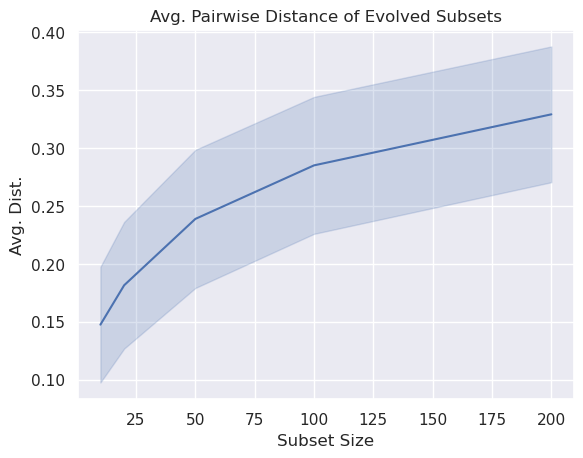

In [109]:
ax = sns.lineplot(data=df, x="Subset Size", y="Avg. Dist.", errorbar="sd")#, hue="Label", legend=False)
_ = ax.set_title("Avg. Pairwise Distance of Evolved Subsets")

['Afghan_hound' 'African_grey' 'Bernese_mountain_dog' 'French_horn'
 'Italian_greyhound' 'Kerry_blue_terrier' 'bathing_cap' 'binoculars'
 'burrito' 'chain' 'corn' 'crane' 'gazelle' 'giant_panda' 'maillot'
 'malinois' 'medicine_chest' 'mobile_home' 'puck' 'racer' 'revolver'
 'spatula' 'television' 'toilet_tissue' 'umbrella' 'warthog' 'wild_boar']
['n02088094' 'n01817953' 'n02107683' 'n03394916' 'n02091032' 'n02093859'
 'n02807133' 'n02841315' 'n07880968' 'n02999410' 'n12144580' 'n02012849'
 'n03126707' 'n02423022' 'n02510455' 'n03710637' 'n03710721' 'n02105162'
 'n03742115' 'n03776460' 'n04019541' 'n04037443' 'n04086273' 'n04270147'
 'n04404412' 'n15075141' 'n04507155' 'n02397096' 'n02396427']


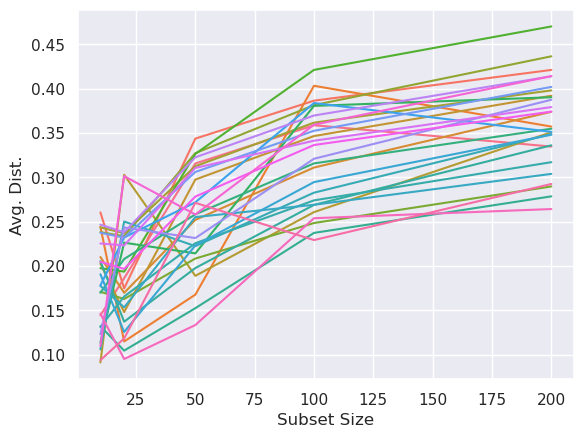

In [124]:
def get_decreasing(group):
    dists = group["Avg. Dist."]
    has_decrease = np.any([n1 > n2 for n1, n2 in zip(dists, dists.iloc[1:])])
    if has_decrease:
        return group
    else:
        return pd.DataFrame()

non_monotonics = df.groupby("Label").apply(get_decreasing)
print(non_monotonics["Label"].unique())
print(non_monotonics["Class ID"].unique())
ax = sns.lineplot(data=non_monotonics, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)

In [102]:
df#.to_pickle("evolved_subset_fitnesses.pkl")

,Class ID,Label,Subset Size,Avg. Dist.
0,n01440764,tench,10,0.180353
1,n01440764,tench,20,0.209126
2,n01440764,tench,50,0.240166
3,n01440764,tench,100,0.270542
4,n01440764,tench,200,0.299189
...,...,...,...,...
4995,n15075141,toilet_tissue,10,0.204570
4996,n15075141,toilet_tissue,20,0.196619
4997,n15075141,toilet_tissue,50,0.278168
4998,n15075141,toilet_tissue,100,0.336320
